<a href="https://colab.research.google.com/github/RaCasas26/DataScience2-FinalProject/blob/main/final_S21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Final Project
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook
## Due 2021-05-14

## Background

In North America, Monarch butterflies (*Danaus plexippus*) are one of the many species of insects that migrate during the winter. However, Monarch butterflies that inhabit other regions such as the Pacific or South America are known to not migrate. A study by Freedman et al. (2020) considers the differences in physical traits between nonmigratory and migratory Monarch butterflies. Specifically, the reserachers of this study compared the differences betweens in the forewing length between Monarch butterflies in North America, the Pacific, the Atlantic, South America, and Australia. By conducting a time series analyses on data collected since 1856, the researchers determined that not only did migratory Monarch butterflies have larger forewings than their nonmigratory counterparts but that the wing size of nonmigratory butterflies reduced over a period of 1000 years.

The dataset appied in this study that considered several variables pertaining to the physical characteristics of different Monarch butterfly samples caught in the wild and in captivity throughout North America, South America, and Australia as well as throughout the Pacific and Atlantic regions. To explore potential models from this dataset, classifiers and regressors were considered in predicting the area a Monarch butterfly comes from as well as in predicting the era the butterfly was caught based off of the physical traits given in this study.

## Data Processing and Exploration

In [ ]:
! pip install --upgrade numpy
! pip install --upgrade pandas

Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.4)


In [ ]:
import numpy as np
import pandas as pd
import requests
import io
from copy import deepcopy  
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 25)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Find the wings_04.25.20.csv file in the Files menu on the left
# Right click the file and click Copy Path
# Paste the path between the quotation marks below
path = "/content/drive/MyDrive/Data_ScienceS21_Final/wings_04.25.20.csv"
df = pd.read_csv(path)

### Dataset
The dataset given has 5367 data points with a total of 53 variables. Of those variables, the ones of interest were the region and country the butterfly was collected, the sex of the butterfly, and the butterfly's forewing measurements. As a result, only 25 variables were considered in the making of the models. \\
Many values were missing in this dataset so many observations had to be removed or imputed. Since butterfly wings are symmetric, measurements for the left forewing were replaced with the measurements of the right forewing if any of those values were missing and vice versa if measurements of the right forewing were missing. If both measurements were missing, the observation was dropped from the dataset. \\
The study by Freedman et al. (2020) applied PCA to the forewing length, width, and area to create the size principal conponenent which accounted for 96.4% of the forewing size variation and the study applied PCA to the forewing aspect ratio and roundness to create the shape principal component which accounted for 86% of the forewing shape variation. These principal components were created in a similar fashion in order to be applied to the analysis. 
 

In [ ]:
df_orig = df.copy()

#Removes variables not involved in analysis
df = df.drop(['Index','SampleID','Collection', 'Island/State', 'County/District', 'Site/City', 'exact_location?',
       'lon', 'Wild-Caught?', 'image_type', 'smoothing', 'Host_plant','observer'], axis=1)

#Converts date into year from its original format (YYYYDDMM)
df['Collection_Year'] = (df['Collection_Date'] * 10 ** (-4)).round(0)
#Removes Collection Date which will not be used in the analysis
df = df.drop('Collection_Date', axis=1)

#Removes the gyandromorph sex so that only male and female monarch butterlies are considered for the analysis
df = df[df['Sex'] != "gyandromorph"]

#Removes observations which had no location of capture 
df = df[pd.notna(df['Region'])]
#Removes observations in the Indian Ocean which are too few for analysis
df = df[df['Region'] != 'Indian_Ocean']

#Binarizes the sexes
df = df.replace(to_replace={'male': 0, 'female': 1})

In [ ]:
vals = ['Length', 'Width', 'Area', 'Perimeter']
for v in vals:
    cols = [f'{s}{v}' for s in ['L', 'R']]
    f = np.nanmean(df[cols], axis=1)
    # print(f)
    for c in cols:
        mask = df[c].isnull()
        df.loc[mask, c] = f[mask]
    df.dropna(subset=cols, inplace=True)

In [ ]:
#Calculates Aspect Ration and Roundness of left and right forewings, respectively
df['LAspect_Ratio'] = df['LLength']/df['LWidth']
df['RAspect_Ratio'] = df['RLength']/df['RWidth']
df['LRoundness'] = 4*np.pi*df['LArea'] / df['LPerimeter'] ** 2
df['RRoundness'] = 4*np.pi*df['RArea'] / df['RPerimeter'] ** 2

In [ ]:
#Binarizes the 'overwintering?' variable
df = df.replace(to_replace={'no': 0, 'yes': 1})

In [ ]:
df = pd.DataFrame(df.to_numpy(), columns=['Region', 'Country/Archipelago', 'lat', 'overwintering?', 'Sex',
       'LLength', 'LWidth', 'LArea', 'LPerimeter', 'RLength', 'RWidth',
       'RArea', 'RPerimeter', 'Collection_Year', 'LAspect_Ratio',
       'RAspect_Ratio', 'LRoundness', 'RRoundness'])
df[['lat', 'overwintering?', 'Sex','LLength', 'LWidth', 'LArea', 'LPerimeter', 'RLength', 'RWidth',
       'RArea', 'RPerimeter', 'Collection_Year', 'LAspect_Ratio',
       'RAspect_Ratio', 'LRoundness', 'RRoundness']] = df[['lat', 'overwintering?', 'Sex','LLength', 'LWidth', 'LArea', 'LPerimeter', 'RLength', 'RWidth',
       'RArea', 'RPerimeter', 'Collection_Year', 'LAspect_Ratio',
       'RAspect_Ratio', 'LRoundness', 'RRoundness']].astype('float64')

In [ ]:
#Applies PCA to compute the first components describing size and shape as described in Freedman et al. (2020)
SizePC1 = pd.DataFrame(PCA(n_components=1, random_state=42).fit_transform(df[['LLength', 'LWidth', 'LArea', 'RLength', 'RWidth', 'RArea']]), columns= ['SizePC1'])
ShapePC1 = pd.DataFrame(PCA(n_components=1, random_state=42).fit_transform(df[['LAspect_Ratio','RAspect_Ratio', 'LRoundness', 'RRoundness']]), columns= ['ShapePC1'])
df = pd.concat([df.reindex(index=ShapePC1.index), ShapePC1, SizePC1], axis=1)

In [ ]:
df.describe()

,lat,overwintering?,Sex,LLength,LWidth,LArea,LPerimeter,RLength,RWidth,RArea,RPerimeter,Collection_Year,LAspect_Ratio,RAspect_Ratio,LRoundness,RRoundness,ShapePC1,SizePC1
count,6560.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.000000,6589.00000,6589.000000,6589.000000,6123.000000,6589.000000,6589.000000,6589.000000,6589.000000,6.589000e+03,6.589000e+03
mean,13.310120,0.044316,0.444377,4.911631,2.506502,8.004036,11.779823,4.926687,2.50809,8.042228,11.820600,1961.449943,1.960393,1.965098,0.722211,0.720750,-8.154174e-17,9.608678e-16
std,25.139305,0.205812,0.496934,0.356998,0.177482,1.061390,0.850554,0.359470,0.17692,1.061425,0.853559,34.949535,0.066570,0.067042,0.020638,0.021711,9.180988e-02,1.589064e+00
min,-40.857807,0.000000,0.000000,3.211000,1.625000,3.542000,7.731000,2.935000,1.67000,3.606000,7.806000,1856.000000,1.546780,1.000341,0.570151,0.583013,-6.625055e-01,-6.088675e+00
25%,-6.801374,0.000000,0.000000,4.709000,2.407000,7.386000,11.299000,4.722000,2.41100,7.421000,11.338000,1935.000000,1.919387,1.922643,0.709687,0.708001,-5.638972e-02,-1.080165e+00
50%,18.109580,0.000000,0.000000,4.951000,2.525000,8.087000,11.870000,4.972000,2.52500,8.130000,11.922000,1965.000000,1.959316,1.964615,0.722689,0.721771,-8.371775e-04,-1.364584e-01
75%,35.315741,0.000000,1.000000,5.158000,2.626000,8.725000,12.371000,5.178000,2.63000,8.771000,12.419000,1984.000000,2.000390,2.005702,0.735385,0.734510,5.422625e-02,9.176677e-01
max,52.920633,1.000000,1.000000,6.033000,3.219000,12.184000,14.685000,6.011000,3.21500,12.110000,14.653000,2018.000000,2.803137,2.484677,0.801186,0.800982,9.340516e-01,6.841371e+00


Several different questions were considered in the analysis of the dataset:
    
    1. Could physical traits and sex help determine the region the Monarch butterfly was collected?
    2. Could physical traits and sex help determine the country the Monarch butterfly was collected?
    3. Could physical traits and sex help determine where in North America migratory butterflies were originally from? 
    4. Could physical traits, sex, and region help determine what year the butterfly was collected? 

To answer each of these questions, the dataframes were formated to exclude missing values from the target variables and to exclude classes with fewer that 5 observations to aviod issues with the algorithms. All models included the shape and size principal components and the sex of the Monarch butterfly as the predicting variables. Only the model for question 4 inlcuded the region as a predicting variable. 
The dataset for each model was split into modeling and holdouts sets in which 80% of the data was allocated into the modeling set and 20% of the data was allocated into the holdout set using a stratified shuffle split algorithm for the classifiers and a shuffle split algorithm for the regressor. 

In [ ]:
#Modelling datasets for predicting region based on physical traits
df_reg = df[pd.notna(df['Region'])]
X_reg = df_reg[['ShapePC1', 'SizePC1' ,'Sex']]
y_reg = df_reg['Region']

holdout_frac = 0.20
holdout_splitter = StratifiedShuffleSplit(test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_reg, y_reg))
X_reg_m, y_reg_m = X_reg.iloc[model_idx]  , y_reg.iloc[model_idx]
X_reg_h, y_reg_h = X_reg.iloc[holdout_idx], y_reg.iloc[holdout_idx]

In [ ]:
#Modelling datasets for predicting country based on physical traits
df_country = df[pd.notna(df['Country/Archipelago'])]
df_country = df_country[(df['Country/Archipelago'] != 'Tokelau') & 
                (df['Country/Archipelago'] != 'Cape_Verde') &
                (df['Country/Archipelago'] != 'Philippines') &
                (df['Country/Archipelago'] != 'Argentina') &
                (df['Country/Archipelago'] != 'Saint_Lucia') &
                (df['Country/Archipelago'] != 'Kiribati') &
                (df['Country/Archipelago'] != 'Palau') &
                (df['Country/Archipelago'] != 'Kermedec_Islands') &
                (df['Country/Archipelago'] != 'Tobago') &
                (df['Country/Archipelago'] != 'Marshall_Islands') &
                (df['Country/Archipelago'] != 'French_Guyana') &
                (df['Country/Archipelago'] != 'Belize') &
                (df['Country/Archipelago'] != 'Azores') &
                (df['Country/Archipelago'] != 'Cook_Islands') &
                (df['Country/Archipelago'] != 'Bermuda') &
                (df['Country/Archipelago'] != 'Taiwan') &
                (df['Country/Archipelago'] != 'Marquesas')]
#group by, filter
X_ctry = df_country[['ShapePC1', 'SizePC1' ,'Sex']]
y_ctry = df_country['Country/Archipelago']

holdout_frac = 0.20
holdout_splitter = StratifiedShuffleSplit(n_splits = 5, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_ctry, y_ctry))
X_ctry_m, y_ctry_m = X_ctry.iloc[model_idx]  , y_ctry.iloc[model_idx]
X_ctry_h, y_ctry_h = X_ctry.iloc[holdout_idx], y_ctry.iloc[holdout_idx]

In [ ]:
#Modelling datasets for predicting the origin of migratory butterflies in North America based on physical traits
df_lat = df[pd.notna(df['lat'])]
df_lat = df_lat[(df_lat['Region'] == 'North_America') & (df_lat['overwintering?'] == 0)]

X_lat = df_lat[['ShapePC1', 'SizePC1' ,'Sex']]
y_lat = df_lat['lat']

holdout_frac = 0.20
holdout_splitter = ShuffleSplit(test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_lat, y_lat))
X_lat_m, y_lat_m = X_lat.iloc[model_idx]  , y_lat.iloc[model_idx]
X_lat_h, y_lat_h = X_lat.iloc[holdout_idx], y_lat.iloc[holdout_idx]

In [ ]:
#Modelling datasets for predicting year based on physical traits and region
df_yr = df[pd.notna(df['Collection_Year'])]
df_yr = pd.concat([df_yr, pd.get_dummies(df_yr['Region']).astype('float64')], axis = 1).reindex(df_yr.index)

X_yr = df_yr[['ShapePC1', 'SizePC1' ,'Sex', 'Atlantic', 'Caribbean', 'Central_America', 'North_America',
       'Pacific_Islands', 'South_America']]
y_yr = df_yr['Collection_Year']

holdout_frac = 0.20
holdout_splitter = ShuffleSplit(test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_yr, y_yr))
X_yr_m, y_yr_m = X_yr.iloc[model_idx]  , y_yr.iloc[model_idx]
X_yr_h, y_yr_h = X_yr.iloc[holdout_idx], y_yr.iloc[holdout_idx]

## Supervised Model Building and Selection

The classifiers applied were the K-Nearest Neighbors classifier, the Random Forest classifier, and the Linear Support Vector Machine classifier. For all models, three different scalers were used to transform the data. Those being the standard scaler, the min-max scaler, and the robust scalers.
 
For the K-Nearest Neighbor classifier, the hyperparameters of interest were the number of neighbors and the weight function used for the prediction. The number of neighbors chosen were multiples of 5 up until 25 and the weight functions considered were the uniform and distance weight functions. 

For the Random Forest classifier, the hyperparameter of interest was the maximum depth of each decision tree. The maximum depth of each decision tree were multiples of 2 up until 10.

For the Linear Support Vector Machine classifier, the hyperparameter of interest was the regularization parameter, $C$. The parameter $C$ was given by 5 equally spaced points from 0.5 to 3.

For each model, k-fold cross validation was performed using the weighted $F1$-score as a performance metric.

In [ ]:
class TopModel_Classifier:
    def __init__(self, X_m, y_m):
        self.X_m = X_m
        self.y_m = y_m

    def top_knc(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify'  , KNeighborsClassifier())
                            ])

            hyperparams = {
                        'classify__n_neighbors' : np.concatenate((np.arange(1,2), np.arange(5,26,5)), axis = None),
                        'classify__weights' : ['uniform', 'distance']
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='f1_weighted').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'

        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)
        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def top_rfc(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify' , RandomForestClassifier(random_state=42))
                            ])

            hyperparams = {
                        'classify__max_depth' : np.arange(2, 11, 2)
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='f1_weighted').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'


        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)

        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def top_lsvc(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify' , LinearSVC(random_state=42))
                            ])

            hyperparams = {
                            'classify__C': np.arange(0.5, 3.5,0.5)
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='f1_weighted').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'


        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)

        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def best_model(self):
        knc_model = self.top_knc()
        knc_model['model'] = 'knc'
        rfc_model = self.top_rfc()
        rfc_model['model'] = 'rfc'
        lsvc_model = self.top_lsvc()
        lsvc_model['model'] = 'lsvc'

        mask1 = knc_model['score'] == knc_model['score'].max()
        mask2 = rfc_model['score'] == rfc_model['score'].max()
        mask3 = lsvc_model['score'] == lsvc_model['score'].max()

        full_model = [knc_model[mask1], rfc_model[mask2], lsvc_model[mask3]]
        first_highest_score = [knc_model[mask1]['score'].iloc[0], rfc_model[mask2]['score'].iloc[0], lsvc_model[mask3]['score'].iloc[0]]
        return full_model[np.argmax(first_highest_score)]

In [ ]:
TopModel_Classifier(X_reg_m,y_reg_m).best_model()

,classify__max_depth,score,scale,model
13,8,0.437708,robust,rfc


In [ ]:
TopModel_Classifier(X_ctry_m,y_ctry_m).best_model()

,classify__n_neighbors,classify__weights,score,scale,model
20,20,uniform,0.225223,min_max,knc


The regressors applied were the K-Nearest Neighbors regressor, the Random Forest regressor, the Linear Support Vector Machine regressor, the LASSO regressor and the Ridge regressor. For all models, three different scalers were used to transform the data. Those being the standard scaler, the min-max scaler, and the robust scalers.
 
For the K-Nearest Neighbor regressor, the hyperparameters of interest were the number of neighbors and the weight function used for the prediction. The number of neighbors chosen were multiples of 5 up until 25 and the weight functions considered were the uniform and distance weight functions. 

For the Random Forest regressor, the hyperparameter of interest was the maximum depth of each decision tree. The maximum depth of each decision tree were multiples of 2 up until 10.

For the Linear Support Vector Machine regressor, the hyperparameter of interest was the regularization parameter, $C$. The parameter $C$ was given by 5 equally spaced points from 0.5 to 3.

For the LASSO and Ridge regressors, the hyperparameter of interest was the coefficient penalty, $\alpha$. The paramter $\alpha$ was given by 9 equally spaced points from 0.2 to 2.

For each model, k-fold cross validation was performed using $R^2$ as a performance metric.

In [ ]:
class TopModel_Regressor:
    def __init__(self, X_m, y_m):
        self.X_m = X_m
        self.y_m = y_m

    def top_knr(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify'  , KNeighborsRegressor())
                            ])

            hyperparams = {
                        'classify__n_neighbors' : np.concatenate((np.arange(1,2), np.arange(5,26,5)), axis = None),
                        'classify__weights' : ['uniform', 'distance']
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'

        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)
        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def top_rfr(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify' , RandomForestRegressor(random_state=42))
                            ])

            hyperparams = {
                        'classify__max_depth' : np.arange(2, 11, 2)
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'


        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)

        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def top_lsvr(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify' , LinearSVR(random_state=42))
                            ])

            hyperparams = {
                            'classify__C': np.arange(0.5, 3.5,0.5)
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'


        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)

        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def top_las(self):
        scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
        grid_k = {}
        for s in scaler_type:
            pipe = Pipeline([('scale', s()),
                            ('classify'  , Lasso(normalize=False, random_state=42))
                            ])

            hyperparams = {
                        'classify__alpha' : np.linspace(0.2, 2, 9)
                        }
            grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(self.X_m, self.y_m)
        res1 = grid_k["grid_StandardScaler"].cv_results_
        df1 = pd.DataFrame(res1['params'])
        df1['score'] = res1['mean_test_score']
        df1['scale'] = 'standard'

        res2 = grid_k["grid_MinMaxScaler"].cv_results_
        df2 = pd.DataFrame(res2['params'])
        df2['score'] = res2['mean_test_score']
        df2['scale'] = 'min_max'

        res3 = grid_k["grid_RobustScaler"].cv_results_
        df3 = pd.DataFrame(res3['params'])
        df3['score'] = res3['mean_test_score']
        df3['scale'] = 'robust'

        res = [df1, df2, df3]
        df = pd.concat(res, ignore_index = True)
        M = df['score'].quantile(q = 0.95)
        mask = df['score'] > M
        return df[mask].sort_values(by = 'score', ascending = False)

    def top_ridge(self):
            scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
            grid_k = {}
            for s in scaler_type:
                pipe = Pipeline([('scale', s()),
                                ('classify'  , Ridge(normalize=False, random_state=42))
                                ])

                hyperparams = {
                            'classify__alpha' : np.linspace(0.2, 2, 9)
                            }
                grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(self.X_m, self.y_m)
            res1 = grid_k["grid_StandardScaler"].cv_results_
            df1 = pd.DataFrame(res1['params'])
            df1['score'] = res1['mean_test_score']
            df1['scale'] = 'standard'

            res2 = grid_k["grid_MinMaxScaler"].cv_results_
            df2 = pd.DataFrame(res2['params'])
            df2['score'] = res2['mean_test_score']
            df2['scale'] = 'min_max'

            res3 = grid_k["grid_RobustScaler"].cv_results_
            df3 = pd.DataFrame(res3['params'])
            df3['score'] = res3['mean_test_score']
            df3['scale'] = 'robust'

            res = [df1, df2, df3]
            df = pd.concat(res, ignore_index = True)
            M = df['score'].quantile(q = 0.95)
            mask = df['score'] > M
            return df[mask].sort_values(by = 'score', ascending = False)

    def best_model(self):
        knr_model = self.top_knr()
        knr_model['model'] = 'knr'
        rfr_model = self.top_rfr()
        rfr_model['model'] = 'rfr'
        lsvr_model = self.top_lsvr()
        lsvr_model['model'] = 'lsvr'
        las_model = self.top_las()
        las_model['model'] = 'lasso'
        ridge_model = self.top_ridge()
        ridge_model['model'] = 'ridge'

        mask1 = knr_model['score'] == knr_model['score'].max()
        mask2 = rfr_model['score'] == rfr_model['score'].max()
        mask3 = lsvr_model['score'] == lsvr_model['score'].max()
        mask4 = las_model['score'] == las_model['score'].max()
        mask5 = ridge_model['score'] == ridge_model['score'].max()

        full_model = [knr_model[mask1], rfr_model[mask2], lsvr_model[mask3], las_model[mask4], ridge_model[mask5]]
        first_highest_score = [knr_model[mask1]['score'].iloc[0], 
                               rfr_model[mask2]['score'].iloc[0], 
                               lsvr_model[mask3]['score'].iloc[0], 
                               las_model[mask4]['score'].iloc[0], 
                               ridge_model[mask5]['score'].iloc[0]]
        return full_model[np.argmax(first_highest_score)]

In [ ]:
TopModel_Regressor(X_lat_m, y_lat_m).best_model()

,classify__max_depth,score,scale,model
0,2,0.01178,standard,rfr


In [ ]:
TopModel_Regressor(X_yr_m, y_yr_m).best_model()

,classify__max_depth,score,scale,model
13,8,0.033497,robust,rfr


Result Summary: 
- The best model for predicting the region where the Monarch butterfly was collected was the Random Forest classifier which applied a max depth of 8 decision trees and in which the data was scaled by the robust scaler. 

- The best model for predicting the country where the Monarch butterfly was collected was the K-Nearest Neighbors classifier which applied the uniform weight function and 20 neighbors and in which the data was scaled by the min-max scaler. 

- The best model for predicting the latitude in North America where the Monarch butterfly was originally from was the Random Forest regressor which applied a max depth of 2 decision trees and in which the data was scaled by the standard scaler. 

- The best model for predicting the year when the Monarch butterfly was collected was the Random Forest regressor which applied a max depth of 8 decision trees and in which the data was scaled by the robust scaler. 


## Model Performance

Using the best models found in the last section, their performance on the holdout sets were evaluated using weighted $F1$-score and the $R^2$ score for the classifiers and regressors, respectively.

In [ ]:
#Best model for for predicting region based on physical traits
pipe = Pipeline([('scale', RobustScaler()),
                ('classify', RandomForestClassifier(max_depth=8, random_state=42))
                ])
y_true = y_reg_h
y_pred = pipe.fit(X_reg_m,y_reg_m).predict(X_reg_h) 
reg_f1 = f1_score(y_true, y_pred, average='weighted')
pd.DataFrame([reg_f1], columns=['Weighted F1'])

,Weighted F1
0,0.400797


In [ ]:
#Best model for for predicting country based on physical traits
pipe = Pipeline([('scale', MinMaxScaler()),
                ('classify', KNeighborsClassifier(n_neighbors=20, weights='uniform'))
                ])
y_true = y_ctry_h
y_pred = pipe.fit(X_ctry_m,y_ctry_m).predict(X_ctry_h) 
ctry_f1 = f1_score(y_true, y_pred, average='weighted')
pd.DataFrame([ctry_f1], columns=['Weighted F1'])

,Weighted F1
0,0.220113


In [ ]:
#Best model for predicting the origin of migratory butterflies in North America based on physical traits
pipe = Pipeline([('scale', StandardScaler()),
                ('classify', RandomForestRegressor(max_depth=2, random_state=42))
                ])
y_true = y_lat_h
y_pred = pipe.fit(X_lat_m,y_lat_m).predict(X_lat_h) 
lat_R2 = r2_score(y_true, y_pred)
pd.DataFrame([lat_R2], columns=['R2'])

,R2
0,-0.000482


In [ ]:
#Best model for predicting the origin of migratory butterflies in North America based on physical traits
pipe = Pipeline([('scale', StandardScaler()),
                ('classify', RandomForestRegressor(max_depth=8, random_state=42))
                ])
y_true = y_yr_h
y_pred = pipe.fit(X_yr_m,y_yr_m).predict(X_yr_h) 
yr_R2 = r2_score(y_true, y_pred)
pd.DataFrame([yr_R2], columns=['R2'])

,R2
0,0.037975


The models applied to the holdout sets for *Aedes aegypti* and both species had positive results. The R squared value suggests that around 43% of the variance of the mosquito counts can be explained by the model. In additions to this, the RMSE suggests that the model deviated on average by around 7 mosquitoes from the true counts. One issue that may come from this model is the maximum depth for the Random Forest Regressor. Normally, components of random forests, decision trees, tend to overfit when the maximum depth of these trees is too high. For that reason, there may be some issues in regards to generalizing this model to future data points.  

The model applied to the holdout set for *Aedes albopictus* did relatively poorly. Although the RMSE suggests that the model deviated on average by around 1 mosquito from the true counts, the R squared value suggest that only around 3% of the variance of the mosquito counts can be explained by the model. This is likely due to underfitting since the K-Nearest Neighbors algorithm tends to underfit the data as the number of neighbors increases. Another factor that may have played a part in this score is the fact that most of the data values for this species was 0. 

## Optimization and Other Models

In [ ]:
X_reg = df_reg[['LLength', 'LWidth', 'LArea', 'LPerimeter', 'RLength', 'RWidth', 'RArea', 'RPerimeter','Sex']]
y_reg = df_reg['Region']

holdout_frac = 0.20
holdout_splitter = StratifiedShuffleSplit(test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_reg, y_reg))
X_reg_m, y_reg_m = X_reg.iloc[model_idx]  , y_reg.iloc[model_idx]
X_reg_h, y_reg_h = X_reg.iloc[holdout_idx], y_reg.iloc[holdout_idx]

In [ ]:
X_ctry = df_country[['LLength', 'LWidth', 'LArea', 'LPerimeter', 'RLength', 'RWidth', 'RArea', 'RPerimeter','Sex']]
y_ctry = df_country['Country/Archipelago']

holdout_frac = 0.20
holdout_splitter = StratifiedShuffleSplit(n_splits = 5, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_ctry, y_ctry))
X_ctry_m, y_ctry_m = X_ctry.iloc[model_idx]  , y_ctry.iloc[model_idx]
X_ctry_h, y_ctry_h = X_ctry.iloc[holdout_idx], y_ctry.iloc[holdout_idx]

In [ ]:
def top_knc(X_m, y_m):
    pipe = Pipeline([('scale', MinMaxScaler()),
                    ('classify'  , KNeighborsClassifier())
                    ])

    hyperparams = {
                'classify__n_neighbors' : np.arange(1,26),
                'classify__weights' : ['uniform', 'distance']
                }
    grid = GridSearchCV(pipe, hyperparams, cv=10, scoring='f1_weighted').fit(X_m, y_m)
    res = grid.cv_results_
    df = pd.DataFrame(res['params'])
    df['score'] = res['mean_test_score']
    df['scale'] = 'min_max'

    M = df['score'].quantile(q = 0.9)
    mask = df['score'] > M
    return df[mask].sort_values(by = 'score', ascending = False)

In [ ]:
def top_rfc(X_m, y_m):
    pipe = Pipeline([('scale', RobustScaler()),
                    ('classify' , RandomForestClassifier(random_state=42))
                    ])

    hyperparams = {
                'classify__max_depth' : np.arange(1, 15)
                }
    grid = GridSearchCV(pipe, hyperparams, cv=10, scoring='f1_weighted').fit(X_m, y_m)
    res = grid.cv_results_
    df = pd.DataFrame(res['params'])
    df['score'] = res['mean_test_score']
    df['scale'] = 'robust'

    M = df['score'].quantile(q = 0.9)
    mask = df['score'] > M
    return df[mask].sort_values(by = 'score', ascending = False)

In [ ]:
top_rfc(X_reg_m, y_reg_m)

,classify__max_depth,score,scale
10,11,0.449846,robust
13,14,0.449811,robust


In [ ]:
#Best optimized model for for predicting region based on physical traits
pipe = Pipeline([('scale', RobustScaler()),
                ('classify', RandomForestClassifier(max_depth=11, random_state=42))
                ])
y_true = y_reg_h
y_pred = pipe.fit(X_reg_m,y_reg_m).predict(X_reg_h) 
reg_f1 = f1_score(y_true, y_pred, average='weighted')
pd.DataFrame([reg_f1], columns=['Weighted F1'])

,Weighted F1
0,0.45947


In [ ]:
top_knc(X_ctry_m, y_ctry_m)

,classify__n_neighbors,classify__weights,score,scale
20,11,uniform,0.233033,min_max
24,13,uniform,0.232536,min_max
26,14,uniform,0.231351,min_max
18,10,uniform,0.230556,min_max
42,22,uniform,0.230447,min_max


In [ ]:
#Best optimized model for for predicting country based on physical traits
pipe = Pipeline([('scale', MinMaxScaler()),
                ('classify', KNeighborsClassifier(n_neighbors=11, weights='uniform'))
                ])
y_true = y_ctry_h
y_pred = pipe.fit(X_ctry_m,y_ctry_m).predict(X_ctry_h) 
ctry_f1 = f1_score(y_true, y_pred, average='weighted')
pd.DataFrame([ctry_f1], columns=['Weighted F1'])

,Weighted F1
0,0.238106


In [ ]:
import tensorflow as tf

In [ ]:
reg_class = df_reg['Region'].unique()

In [ ]:
df_reg_shuffle = pd.concat([X_reg_m, y_reg_m], axis = 1)
df_reg_shuffle['Region'] = pd.Categorical(df_reg_shuffle['Region'])
df_reg_shuffle['Region'] = df_reg_shuffle.Region.cat.codes
y_reg_m = df_reg_shuffle.pop('Region')
X_reg_m = df_reg_shuffle

df_reg_shuffle = pd.concat([X_reg_h, y_reg_h], axis = 1)
df_reg_shuffle['Region'] = pd.Categorical(df_reg_shuffle['Region'])
df_reg_shuffle['Region'] = df_reg_shuffle.Region.cat.codes
y_reg_h = df_reg_shuffle.pop('Region')
X_reg_h = df_reg_shuffle

In [ ]:
data_reg_neural_m = tf.data.Dataset.from_tensor_slices((X_reg_m.values, y_reg_m.values))
train_dataset = data_reg_neural_m.shuffle(len(X_reg_m)).batch(1)

data_reg_neural_h = tf.data.Dataset.from_tensor_slices((X_reg_h.values, y_reg_h.values))
holdout_dataset = data_reg_neural_h.shuffle(len(X_reg_h)).batch(1)

In [ ]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['categorical_accuracy'])
  return model

In [ ]:
model = get_compiled_model()
model.fit(train_dataset, epochs=5)

Epoch 1/3
5271/5271 [==============================] - 6s 1ms/step - loss: 3.7898e-07 - categorical_accuracy: 1.0000
Epoch 2/3
5271/5271 [==============================] - 5s 1ms/step - loss: 3.7800e-07 - categorical_accuracy: 1.0000
Epoch 3/3
5271/5271 [==============================] - 5s 1ms/step - loss: 3.7822e-07 - categorical_accuracy: 1.0000


In [ ]:
model.evaluate(holdout_dataset)

1318/1318 [==============================] - 1s 748us/step - loss: 3.7843e-07 - categorical_accuracy: 1.0000


[3.784307125442865e-07, 1.0]

In [ ]:
df_ctry_shuffle = pd.concat([X_ctry_m, y_ctry_m], axis = 1)
df_ctry_shuffle['Country/Archipelago'] = pd.Categorical(df_ctry_shuffle['Country/Archipelago'])
df_ctry_shuffle['Country/Archipelago'] = df_ctry_shuffle['Country/Archipelago'].cat.codes
y_ctry_m = df_ctry_shuffle.pop('Country/Archipelago')
X_ctry_m = df_ctry_shuffle

df_ctry_shuffle = pd.concat([X_ctry_h, y_ctry_h], axis = 1)
df_ctry_shuffle['Country/Archipelago'] = pd.Categorical(df_ctry_shuffle['Country/Archipelago'])
df_ctry_shuffle['Country/Archipelago'] = df_ctry_shuffle['Country/Archipelago'].cat.codes
y_ctry_h = df_ctry_shuffle.pop('Country/Archipelago')
X_ctry_h = df_ctry_shuffle

In [ ]:
data_ctry_neural_m = tf.data.Dataset.from_tensor_slices((X_ctry_m.values, y_ctry_m.values))
train_dataset = data_ctry_neural_m.shuffle(len(X_ctry_m)).batch(1)

data_ctry_neural_h = tf.data.Dataset.from_tensor_slices((X_ctry_h.values, y_ctry_h.values))
holdout_dataset = data_ctry_neural_h.shuffle(len(X_ctry_h)).batch(1)

In [ ]:
model = get_compiled_model()
model.fit(train_dataset, epochs=5)

Epoch 1/5
5233/5233 [==============================] - 6s 1ms/step - loss: 3.1985e-06 - categorical_accuracy: 1.0000
Epoch 2/5
5233/5233 [==============================] - 5s 1ms/step - loss: 3.1682e-06 - categorical_accuracy: 1.0000
Epoch 3/5
5233/5233 [==============================] - 5s 1ms/step - loss: 3.1861e-06 - categorical_accuracy: 1.0000
Epoch 4/5
5233/5233 [==============================] - 5s 1ms/step - loss: 3.1210e-06 - categorical_accuracy: 1.0000
Epoch 5/5
5233/5233 [==============================] - 5s 1ms/step - loss: 3.2347e-06 - categorical_accuracy: 1.0000


In [ ]:
model.evaluate(holdout_dataset)

1309/1309 [==============================] - 1s 726us/step - loss: 3.1803e-06 - categorical_accuracy: 1.0000


[3.1803108413441805e-06, 1.0]

## Conclusion

In this project, the data collected on the number of mosquitoes for two different species caught in traps throughout Brownsville, TX, was explored. By applying three different regression algorithms, the number of mosquitoes was predicted from ecological and meteorological variables. Overall, it was shown that the Random Forest regressor gave the best results when applied to the *Aedes aegypti* species and to both species collectively. However, the best model calculated for the *Aedes albopictus* species performed poorly with respect to the R squared score likely due to underfitting. These results are summarized in the tables and charts below.  

In [ ]:
aeg_model_best_rev = aeg_model_best.rename(columns={'classify__max_depth': 'max depth',
                                                    'dim_reduce__n_components': 'reduced dimension',
                                                    'score': 'R2 score'})
aeg_model_best_rev.at[0,'model'] = 'random forest'
aeg_model_best_rev

,max depth,reduced dimension,R2 score,scale,model,species
0,10,15,0.388783,robust,random forest,aeg


In [ ]:
alb_model_best_rev = alb_model_best.rename(columns={'classify__n_neighbors': 'neighbors',
                                                    'classify__weights': 'weight',
                                                    'dim_reduce__n_components': 'reduced dimension',
                                                    'score': 'R2 score'})
alb_model_best_rev.at[0,'model'] = 'k-nearest neighbors'
alb_model_best_rev


,neighbors,weight,reduced dimension,R2 score,scale,model,species
0,15,uniform,10,0.277847,standard,k-nearest neighbors,alb


In [ ]:
tot_model_best_rev = aeg_model_best.rename(columns={'classify__max_depth': 'max depth',
                                                    'dim_reduce__n_components': 'reduced dimension',
                                                    'score': 'R2 score'})
tot_model_best_rev.at[0,'model'] = 'random forest'
tot_model_best_rev.at[0,'species'] = 'both'
tot_model_best_rev

,max depth,reduced dimension,R2 score,scale,model,species
0,10,15,0.388783,robust,random forest,both


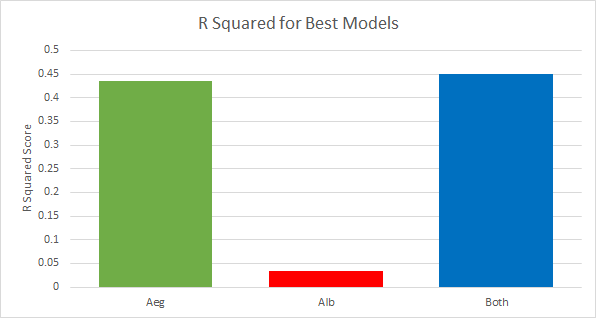









If there was more time to pursue this project, the performance of the second best models could be considered. In addition, Support Vector Machine regression, Ridge regression, and Elastic-Net regression are other models that could be applied to the dataset as well. The application of other ensemble methods such as Gradient Boosting regression to the data set is an option that could be explored as well. 

## References
- Freedman, M. G., Dingle, H., Strauss, S. Y., & Ramírez, S. R. (2020). Two centuries of monarch butterfly collections reveal contrasting effects of range expansion and migration loss on wing traits. *Proceedings of the National Academy of Sciences, 117*(46), 28887-28893.
